In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
from mantid.simpleapi import LoadMD

In [2]:
%matplotlib notebook

In [3]:
!ls ../Data/Fitting

HB1_exp0762_scan0072.dat  NaCl.npy  NaCl.nxs


In [4]:
MDdata = LoadMD('../Data/Fitting/NaCl.nxs')

In [5]:
data = MDdata.getSignalArray().copy().squeeze()
data[np.isnan(data)]=0

In [6]:
dim_x = MDdata.getXDimension()
dim_y = MDdata.getZDimension()
x = np.linspace(dim_x.getMinimum(),dim_x.getMaximum(),dim_x.getNBins())
y = np.linspace(dim_y.getMinimum(),dim_y.getMaximum(),dim_y.getNBins())

In [7]:
data.shape

(801, 801)

In [8]:
xmat,ymat=np.meshgrid(x,y)

<IPython.core.display.Javascript object>


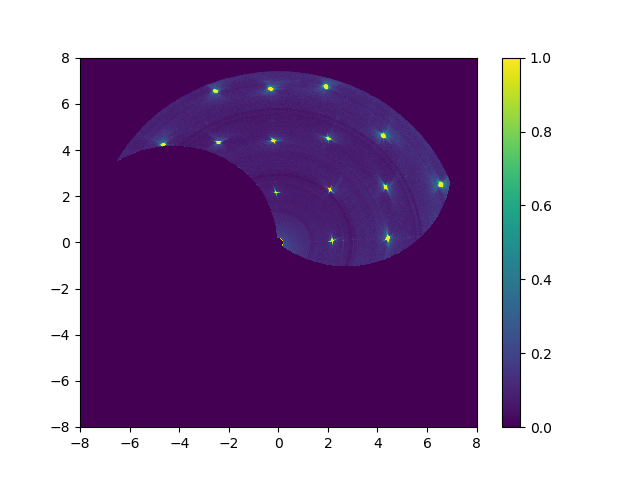

In [9]:
f1,ax=plt.subplots()
cax=ax.pcolor(xmat,ymat,data,vmax=1)
f1.colorbar(cax)

Select one peak with slicing

In [10]:
data_slice = data[720:760,460:540]
xmat_slice = xmat[720:760,460:540]
ymat_slice = ymat[720:760,460:540]

<IPython.core.display.Javascript object>


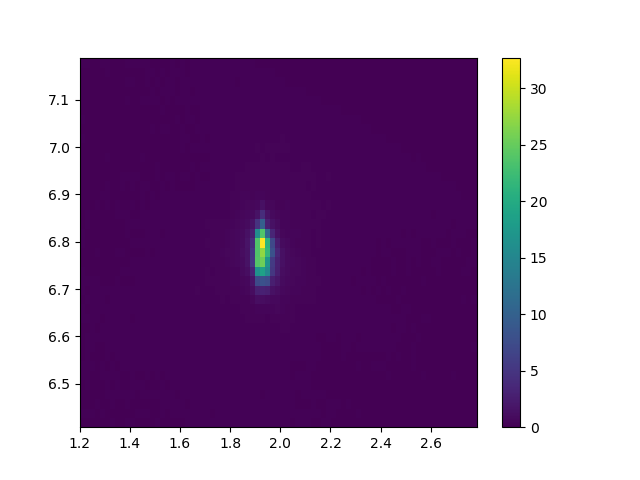

In [11]:
f1,ax=plt.subplots()
cax=ax.pcolor(xmat_slice,ymat_slice,data_slice)
f1.colorbar(cax)

In [12]:
def rotz(theta):
    return np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

In [13]:
def Gauss2D(x,y,A,sig1,sig2,theta,cx,cy,b):
    xmax=len(x)
    X=np.vstack((x,y))
    Sigma=np.array([[sig1*sig1,0],[0,sig2*sig2]])
    Sigmainv=np.linalg.inv(Sigma)
    sqdetsig=np.linalg.det(Sigma)
    mu=np.array([cx,cy])
    G=np.zeros(xmax)
    for idx in range(xmax):
       XmmuR=np.dot(rotz(theta),(X[:,idx]-mu))
       G[idx] =b+ A/sqdetsig*np.exp(-0.5*np.dot((XmmuR),np.dot(Sigmainv,(XmmuR))))
    return G

In [14]:
model=Model(Gauss2D,independent_vars=['x','y'])

Use center as starting point

In [15]:
cx=np.mean(xmat_slice)
cy=np.mean(ymat_slice)
print('cx = {}, cy = {}'.format(cx,cy))

cx = 1.9924875569343568, cy = 6.798487694263458


In [16]:
model.set_param_hint('A',value=100)
model.set_param_hint('sig1',value=0.1)
model.set_param_hint('sig2',value=0.1)
model.set_param_hint('theta',value=0,min=0,max=np.pi/2.)
model.set_param_hint('cx',value=cx)
model.set_param_hint('cy',value=cy)
model.set_param_hint('b',value=0)

In [17]:
#result=model.fit(Gdat,x=xmat,y=ymat,weights=1./np.sqrt(Gdat))
result=model.fit(data_slice.ravel(),x=xmat_slice.ravel(),y=ymat_slice.ravel())

In [18]:
print(result.fit_report())

[[Model]]
    Model(Gauss2D)
[[Fit Statistics]]
    # function evals   = 136
    # data points      = 3200
    # variables        = 7
    chi-square         = 240.381
    reduced chi-square = 0.075
    Akaike info crit   = -8269.782
    Bayesian info crit = -8227.286
[[Variables]]
    A:       2.6216e-05 +/- 2.64e-07 (1.01%) (init= 100)
    sig1:    0.03864047 +/- 0.000173 (0.45%) (init= 0.1)
    sig2:    0.02313172 +/- 0.000104 (0.45%) (init= 0.1)
    theta:   1.55923816 +/- 0.005574 (0.36%) (init= 0)
    cx:      1.92137869 +/- 0.000103 (0.01%) (init= 1.992488)
    cy:      6.76946821 +/- 0.000173 (0.00%) (init= 6.798488)
    b:       0.15095427 +/- 0.004893 (3.24%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(A, sig1)                   =  0.673 
    C(A, sig2)                   =  0.672 
    C(A, b)                      = -0.119 



<IPython.core.display.Javascript object>


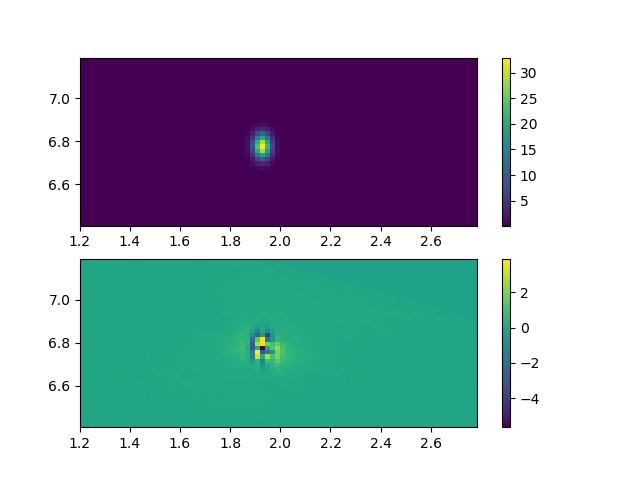

In [19]:
f3,ax3=plt.subplots(2,1)
c0=ax3[0].pcolor(xmat_slice,ymat_slice,result.best_fit.reshape(xmat_slice.shape))
c1=ax3[1].pcolor(xmat_slice,ymat_slice,data_slice-result.best_fit.reshape(xmat_slice.shape))
f3.colorbar(c0,ax=ax3[0])
f3.colorbar(c1,ax=ax3[1])